# Iterative forecasting

Iterative forecasting (sometimes called recursive) involves repeatedly predicting 
with a forecaster by adding predicted values to the actual values. Suppose you have a series of length $n$ and 
you want to forecast the next 20 steps, the pseudocode for this is as follows.

```
call f.fit(y)
for i ← 1 to predictive_horizon do
    preds[i - 1] ← f.predict(y)
    y.append(preds[i - 1])
end for
```
 In contrast to [direct forecasting](./direct.ipynb), the iterative forecast only 
 ever fits a single model. You can visualise the process as follows

<img src="./img/iterative.png" width="600" alt="iterative forecasting">


We will demonstrate direct forecasting with the airline data

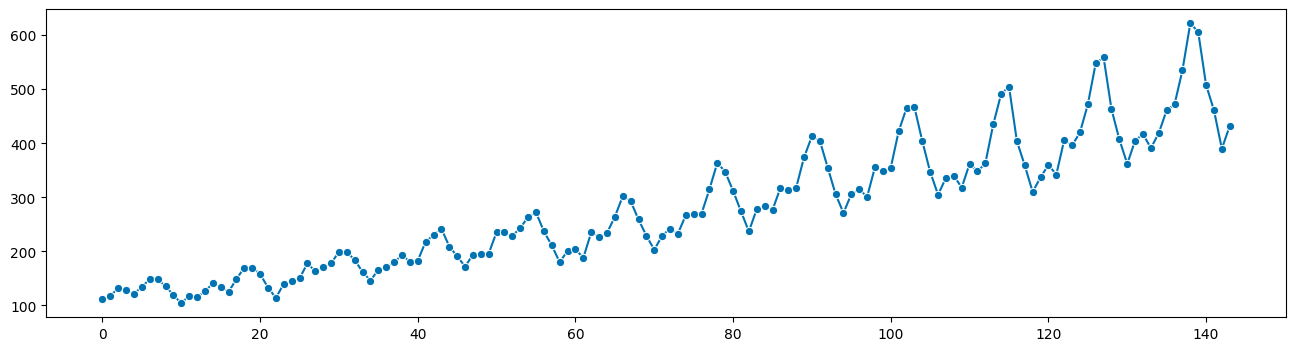

In [1]:
from aeon.datasets import load_airline
from aeon.visualisation import plot_series

airline = load_airline()
_ = plot_series(airline)

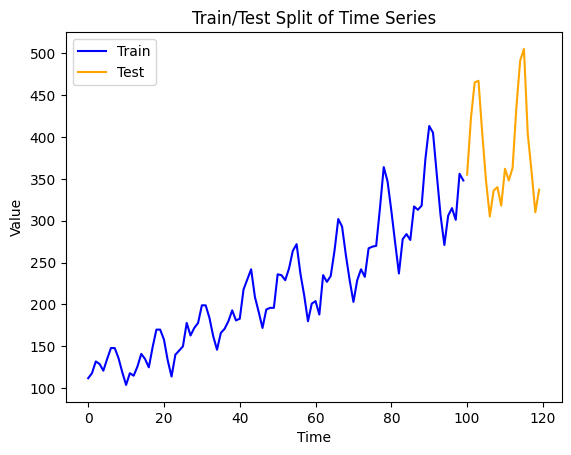

In [2]:
import matplotlib.pyplot as plt
import numpy as np

y_train = airline[:100]
y_test = airline[100:120]
plt.plot(np.arange(0, len(y_train)), y_train, label="Train", color="blue")
plt.plot(
    np.arange(len(y_train), len(y_train) + len(y_test)),
    y_test,
    label="Test",
    color="orange",
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Train/Test Split of Time Series")
plt.show()

We want to train a forecaster on the train set and forecast predictions for the
subsequent test steps. The `RegressionForecaster` is a window based forecaster that 
by default uses linear regression to predict one step ahead. It requires a window 
parameter. See the [forecasting with regression](./regression.ipynb) notebook for 
details. The `forecast()` method makes a single forecast `horizon` steps ahead. 

In [3]:
from aeon.forecasting import RegressionForecaster

reg = RegressionForecaster(horizon=1, window=10)
p1 = reg.forecast(y_train)
print(" First forecast = ", p1)

 First forecast =  376.1051346580682


what if we want to predict further ahead? The direct strategy, described [here](./direct.ipynb)
retrains the model for each set, changing the forecasting horizon. This can
 be computationally intensive. As an alternative, the iterative 
 strategy uses the predicted value and predicts without refitting.

In [4]:
y_new = np.append(y_train, p1)
p2 = reg.predict(y_new)
y_new = np.append(y_new, p2)
p3 = reg.predict(y_new)
print(f" second forecast = {p2} third forecast = {p3}")

 second forecast = 427.18613539195076 third forecast = 418.4059582875235


there is a function in the base class to make iterative forecasting easier.

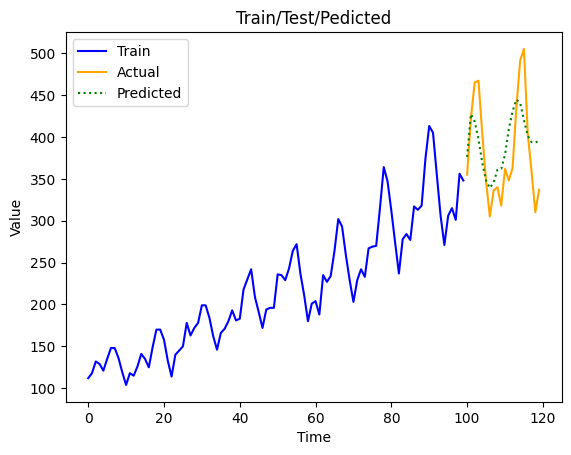

In [5]:
y_hat = reg.iterative_forecast(y=y_train, prediction_horizon=20)

plt.plot(np.arange(0, len(y_train)), y_train, label="Train", color="blue")
plt.plot(
    np.arange(len(y_train), len(y_train) + len(y_test)),
    y_test,
    label="Actual",
    color="orange",
)
plt.plot(
    np.arange(len(y_train), len(y_train) + len(y_hat)),
    y_hat,
    label="Predicted",
    color="green",
    linestyle=":",
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Train/Test/Pedicted")
plt.show()

Looking closer, we can see the errors our forecaster is making.

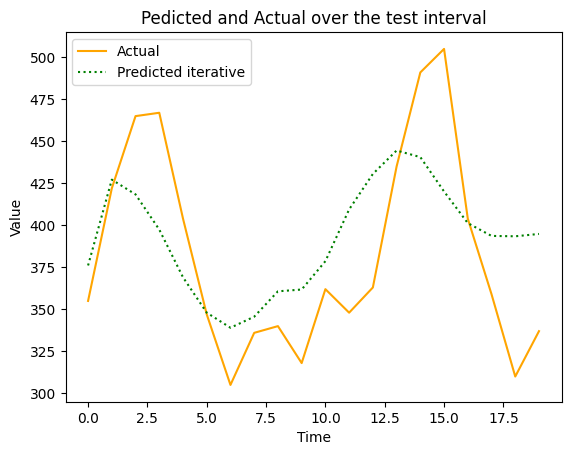

In [6]:
plt.plot(y_test, label="Actual", color="orange")
plt.plot(y_hat, label="Predicted iterative", color="green", linestyle=":")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Pedicted and Actual over the test interval")
plt.show()

It seems to be underestimating the peaks and troughs. Contrast this to the direct 
strategy which results in very different forecasts 

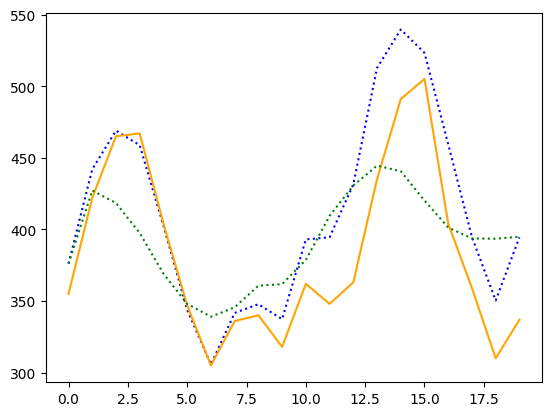

In [7]:
y_hat2 = reg.direct_forecast(y=y_train, prediction_horizon=20)
plt.plot(y_hat2, label="Predicted direct", color="blue", linestyle=":")
plt.plot(y_test, label="Actual", color="orange")
plt.plot(y_hat, label="Predicted iterative", color="green", linestyle=":")
plt.show()

Alpha: 0.2550646708489574, Beta: 0.02550646708489574, Gamma: 0.7448608356181274, Phi: 1.0
Alpha: 0.25508210344031595, Beta: 2.5508210344031598e-05,         Gamma: 0.7448434047700282,             Phi: N/A


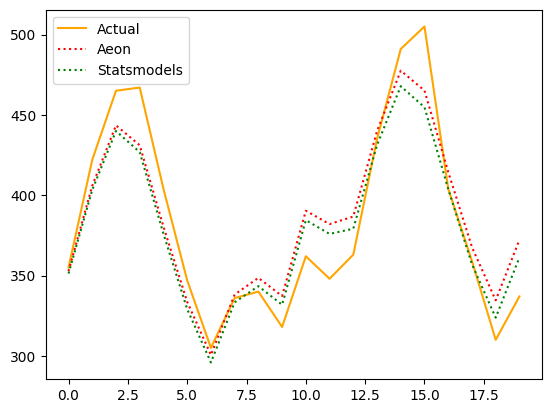

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from aeon.datasets import load_airline
from aeon.forecasting import ETSForecaster

airline = load_airline()
y_train = airline[:100]
y_test = airline[100:120]

ets = ETSForecaster(
    error_type="additive",
    trend_type="additive",
    seasonality_type="additive",
    seasonal_period=12,
    alpha=0.2550646708489574,
    beta=2.550646708489574e-02,
    gamma=0.7448608356181274,
    phi=1.0,
)
statsmodels_ets = ETSModel(
    endog=y_train,
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods=12,
    damped_trend=False,
)

ets_forecasts = ets.iterative_forecast(y_train, 20)
sm_model = statsmodels_ets.fit()
statsmodels_forecasts = sm_model.forecast(steps=20)
print(f"Alpha: {ets.alpha}, Beta: {ets.beta}, Gamma: {ets.gamma}, Phi: {ets.phi}")
print(
    f"Alpha: {sm_model.alpha}, Beta: {sm_model.beta if sm_model.has_trend else 'N/A'}, \
        Gamma: {sm_model.gamma if sm_model.has_seasonal else 'N/A'}, \
            Phi: {sm_model.phi if sm_model.damped_trend else 'N/A'}"
)
# plt.plot(np.arange(0, len(y_train)), y_train, label="Train", color="blue")
plt.plot(
    # np.arange(len(y_train), len(y_train) + len(y_test)),
    y_test,
    label="Actual",
    color="orange",
)
plt.plot(
    # np.arange(len(y_train), len(y_train) + len(ets_forecasts)),
    ets_forecasts,
    label="Aeon",
    color="red",
    linestyle=":",
)
plt.plot(
    # np.arange(len(y_train), len(y_train) + len(statsmodels_forecasts)),
    statsmodels_forecasts,
    label="Statsmodels",
    color="green",
    linestyle=":",
)
plt.legend()
plt.show()